# Описание задачи

Ссылка на данные: https://ods.ai/competitions/mtsmlcup

Можно ли составить хотя бы приблизительное представление о человеке, обладая информацией о сайтах, которые он посещает? Вопрос звучит так: млжно ли по таким цифровым следам пользователя (на каких сайтах с каких IP он сидел, сколько раз заходил, какое у него устройство) понять, кто этот пользователь? Мужчина или женщина? 

Действительно, в Digital-рекламе часто сегмент включает себя пол. Эта задача особенно актуальна для рекламных DSP-площадок, которые в OpenRTB запросах получают такие данные с частотой 200 000 запросов в секунду со всех сайтов, размещающих рекламу за деньги.

Описание данных:
- region_name – Регион;
- city_name – Населенный пункт;
- cpe_manufacturer_name – Производитель устройства;
- cpe_model_name – Модель устройства;
- url_host – Домен, с которого пришел рекламный запрос;
- cpe_type_cd – Тип устройства (смартфон или что-то другое);
- cpe_model_os_type – Операционка на устройстве;
- price – Оценка цены устройства;
- date – Дата;
- part_of_day – Время дня (утро, вечер, итд);
- request_cn – Число запросов одного пользователя за время дня (поле part_of_day);
- user_id – ID пользователя;
- age – Возраст пользователя;
- is_male – Пол пользователя : мужчина (1-Да, 0-Нет).

Target - is_male.

# Import

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import scipy
import yaml
import joblib

import implicit

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [11]:
config_path = '../сonfig/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config['preprocessing']

In [3]:
df = pd.read_parquet(preproc['train_data_path'])

In [4]:
target_train = pd.read_parquet(preproc['target_train_path'])

In [5]:
fin_df = pd.merge(df, target_train, on='user_id')

# EDA+feature engineering

In [6]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21388176 entries, 0 to 21388175
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   region_name            object 
 1   city_name              object 
 2   cpe_manufacturer_name  object 
 3   cpe_model_name         object 
 4   url_host               object 
 5   cpe_type_cd            object 
 6   cpe_model_os_type      object 
 7   price                  float64
 8   date                   object 
 9   part_of_day            object 
 10  request_cnt            int64  
 11  user_id                int64  
 12  age                    float64
 13  is_male                object 
dtypes: float64(2), int64(2), object(10)
memory usage: 2.4+ GB


In [7]:
fin_df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Санкт-Петербург,Санкт-Петербург,Samsung,Galaxy S20+,ad.mail.ru,smartphone,Android,74259.0,2021-09-26,night,1,79395,35.0,1
1,Санкт-Петербург,Санкт-Петербург,Samsung,Galaxy S20+,i.ytimg.com,smartphone,Android,74259.0,2021-08-21,day,3,79395,35.0,1
2,Санкт-Петербург,Санкт-Петербург,Samsung,Galaxy S20+,node3.online.sberbank.ru,smartphone,Android,74259.0,2021-08-20,day,3,79395,35.0,1
3,Калининградская область,Калининград,Samsung,Galaxy S20+,node3.online.sberbank.ru,smartphone,Android,74259.0,2021-09-09,evening,2,79395,35.0,1
4,Санкт-Петербург,Санкт-Петербург,Samsung,Galaxy S20+,play.google.com,smartphone,Android,74259.0,2021-08-30,day,1,79395,35.0,1


In [8]:
fin_df = fin_df[fin_df.cpe_model_os_type != 'Apple iOS']

In [9]:
def save_unique_train_data(data: pd.DataFrame, 
                           target_column: str, 
                           unique_values_path: str) -> None:
    """
    Сохраняет словарь с признаками и уникальными значениями
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = data.drop(columns=target_column, axis=1)
    
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, 'w') as file:
        json.dump(dict_unique, file)

In [10]:
save_unique_train_data(data=fin_df, 
                       drop_columns=preproc['drop_columns_unique'], 
                       target_column=preproc['target_column'], 
                       unique_values_path=preproc['unique_values_path_proc'],
)

In [11]:
def filling_pass(data: pd.DataFrame, list_non: list) -> pd.DataFrame:
    """
    Заполняет пропуски значений в датасете
    :param data: датасет
    :param list_non: список с признаками в которых есть пропуски
    :return: датасет
    """
    for i in list_non:
        if i == 'price':
            data[i].fillna(data[i].median(), inplace=True)
        elif i == 'age':
            data[i].fillna(data[i].mode().iloc[0], inplace=True)
            data.loc[data[i] == 0, i] = data[i].mode().iloc[0]
        elif i == 'is_male':
            data = data[data[i] != 'NA']
            data.dropna(subset=[i], inplace=True)
            data = data.reset_index(drop=True)
    return data

In [12]:
fin_df = filling_pass(data=fin_df, 
                      list_non=preproc['list_non'])

In [13]:
def replace_values(data: pd.DataFrame, map_change_columns: dict) -> pd.DataFrame:
    """
    Заменяет значения в датасете
    :param data: датасет
    :param map_change_columns: словарь с признаками и значениями
    :return: датасет
    """
    data['month'] = pd.to_datetime(data.date).dt.month
    return data.replace(map_change_columns)

In [14]:
fin_df = replace_values(data=fin_df, 
                        map_change_columns=preproc['map_change_columns'])

In [15]:
def get_bins(data: pd.DataFrame, first_val: int,
             second_val: int) -> pd.DataFrame:
    """
    Генерирует бины для разных признаков
    :param data: датасет
    :param first_val: первый порог значения для разбиения на бины
    :param second_val: второй порог значения для разбиения на бины
    :return: датасет
    """
    if key == 'day':
        result = ("one_decade" if data <= first_val else "two_decade" if 
                  first_val < data <= second_val else "three_decade")
    elif key == 'price':
        result = ("cheap_price" if data <= first_val else "middle_price" if 
                  first_val < data <= second_val else "high_price")
    elif key == 'age':
        result = ("young_aged" if data <= first_val else "middle_aged" if 
                  first_val < data <= second_val else "older_aged")
    return result

In [16]:
for key in preproc["map_bins_columns"].keys():
    if key == 'day':
        fin_df['day'] = pd.to_datetime(fin_df.date).dt.day
        fin_df[f"bins_{key}"] = fin_df[key].apply(lambda x: get_bins(x,
        first_val=preproc["map_bins_columns"][key][0],
        second_val=preproc["map_bins_columns"][key][1]))
    else:
        fin_df[f"bins_{key}"] = fin_df[key].apply(lambda x: get_bins(x,
        first_val=preproc["map_bins_columns"][key][0],
        second_val=preproc["map_bins_columns"][key][1]))

In [17]:
def data_drop(data: pd.DataFrame, drop_columns: list) -> pd.DataFrame:
    """
    Удаляет признаки
    :param data: датасет
    :param drop_columns: список с признаками
    :return: датасет
    """
    return data.drop(columns=drop_columns, axis=1)

In [18]:
fin_df = data_drop(data=fin_df, 
                  drop_columns=preproc['drop_columns'])

In [19]:
def transform_types(data: pd.DataFrame, 
                    change_type_columns: dict) -> pd.DataFrame:
    """
    Преобразазует признаки в заданный тип данных
    :param data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return:
    """
    return data.astype(change_type_columns, errors="raise")

In [20]:
fin_df = transform_types(data=fin_df, 
                        change_type_columns=preproc['change_type_columns'])

In [21]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20843671 entries, 0 to 20843670
Data columns (total 15 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   region_name            category
 1   city_name              category
 2   cpe_manufacturer_name  category
 3   cpe_model_name         category
 4   url_host               category
 5   cpe_type_cd            category
 6   cpe_model_os_type      category
 7   part_of_day            category
 8   request_cnt            int8    
 9   user_id                int32   
 10  is_male                int8    
 11  month                  category
 12  bins_day               category
 13  bins_price             category
 14  bins_age               category
dtypes: category(12), int32(1), int8(2)
memory usage: 459.8 MB


In [22]:
fin_df.describe()

,request_cnt,user_id,is_male
count,2.084367e+07,2.084367e+07,2.084367e+07
mean,1.722845e+00,2.064695e+05,5.161101e-01
std,1.211579e+00,1.192499e+05,4.997404e-01
min,1.000000e+00,4.000000e+00,0.000000e+00
25%,1.000000e+00,1.040610e+05,0.000000e+00
50%,1.000000e+00,2.068030e+05,1.000000e+00
75%,2.000000e+00,3.101870e+05,1.000000e+00
max,1.400000e+01,4.152770e+05,1.000000e+00


In [23]:
fin_df.describe(include=['object', 'category'])

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,part_of_day,month,bins_day,bins_price,bins_age
count,20843671,20843671,20843671,20843671,20843671,20843671,20843671,20843671,20843671,20843671,20843671,20843671
unique,80,943,31,482,63055,4,2,4,12,3,3,3
top,Москва,Москва,Apple,iPhone 11,googleads.g.doubleclick.net,smartphone,Android,day,July,three_decade,cheap_price,young_aged
freq,3020605,3020605,7944106,1829145,1416406,20836115,12899565,6918048,7897796,8093341,9265376,10657377


# Гипотезы:

- 1. Регион и населенный пункт влияют на пол владельца HTTP cookie;
- 2. Производитель устройства и его модель с которго были выходы в сеть влияют на пол;
- 3. Операционная система не влияет на целевую переменную;
- 4. Тип устройства влияет на пол пользователя;
- 5. Цена устройства влияет на пол;
- 6. Женщины делают больше запросов за один день, чем мужчины;
- 7. Женщины более активны в первой половине дня, чем мужчины;
- 8. Среди мужчины больше молодых людей, но в целом возраст не влияет на принадлежность к полу;
- 9. Месяц и его декады не влияют на таргет. 

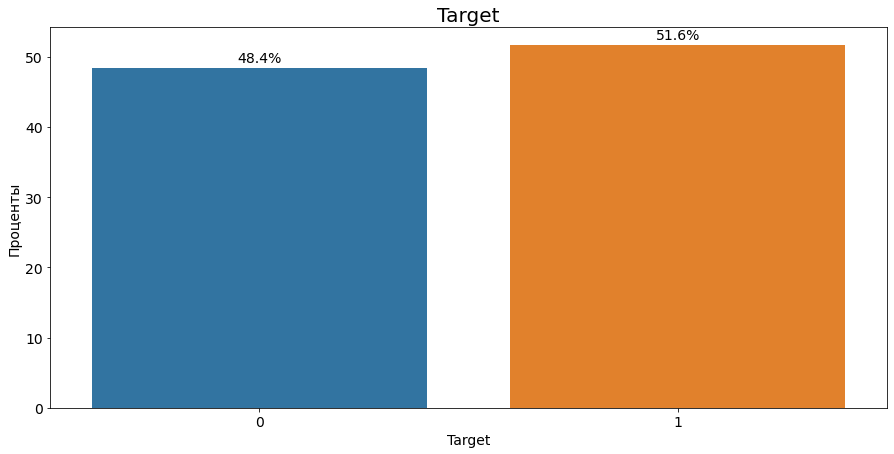

In [24]:
def plot_text(ax: plt.Axes):
    """
    Выводит текст на графике barplot
    """
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)
        
        
# нормирование на размер датасета
norm_target = (fin_df
               .is_male
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='is_male', y='percent', data=norm_target)

plot_text(ax)

plt.title('Target', fontsize=20)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Вывод:**
В датасете дисбаланс классов несущественнен.

## Гипотеза 1:
- Регион и населенный пункт влияют на пол владельца HTTP cookie.

In [25]:
def data_group (data: pd.DataFrame, col_main: str, col_group: str) -> None:
    """
    Группирует, нормирует и выводит данные
    :param data: датасет
    :param col_main: признак для анализа по col_group
    :param col_group: признак для нормализации/группировки
    :return: None
    """
    col_main = (data.groupby([col_group])[col_main]
                .value_counts(normalize=True)
                .rename('Проценты')
                .mul(100)
                .reset_index())
            
    print(col_main[col_main[col_group] == 0][:10], end='\n\n\n')
    print(col_main[col_main[col_group] == 1][:10])

In [26]:
data_group(data=fin_df, 
          col_main='region_name', 
          col_group='is_male')

   is_male              region_name   Проценты
0        0                   Москва  12.398937
1        0       Краснодарский край   8.744520
2        0       Московская область   6.188761
3        0          Санкт-Петербург   5.861725
4        0  Республика Башкортостан   5.092265
5        0     Республика Татарстан   3.891338
6        0     Свердловская область   3.535530
7        0        Самарская область   3.074239
8        0    Новосибирская область   3.050810
9        0       Ростовская область   2.814979


    is_male              region_name   Проценты
80        1                   Москва  16.453839
81        1       Краснодарский край   7.501281
82        1          Санкт-Петербург   6.710893
83        1       Московская область   6.183547
84        1  Республика Башкортостан   4.981590
85        1     Республика Татарстан   4.123436
86        1     Свердловская область   3.779485
87        1    Новосибирская область   3.271641
88        1       Ростовская область   2.757048
8

In [27]:
data_group(data=fin_df, 
          col_main='city_name', 
          col_group='is_male')

   is_male        city_name   Проценты
0        0           Москва  12.398937
1        0  Санкт-Петербург   5.861725
2        0        Краснодар   2.809645
3        0      Новосибирск   2.772049
4        0              Уфа   2.748650
5        0             Сочи   2.088401
6        0     Екатеринбург   1.989304
7        0           Казань   1.779687
8        0           Тюмень   1.778081
9        0            Пермь   1.659600


     is_male        city_name   Проценты
943        1           Москва  16.453839
944        1  Санкт-Петербург   6.710893
945        1      Новосибирск   2.893714
946        1        Краснодар   2.883860
947        1              Уфа   2.844790
948        1     Екатеринбург   2.437600
949        1           Казань   1.999985
950        1           Тюмень   1.600464
951        1           Ижевск   1.569314
952        1             Сочи   1.565140


**Вывод:**
Регион и населенный пункт немного влияют на принадлежность к тому или иному полу. Также видно, что люди из нашей целевой переменной преимущественно проживают в Москве и Санкт-Петербурге. Гипотеза скорее подтвердилась.

## Гипотеза 2:
- Производитель устройства и его модель с которго были выходы в сеть влияют на пол. 

In [28]:
def barplot_group(col_main: str, col_group: str, data: pd.DataFrame, 
                  title: str, grad: int) -> None:
    """
    Строит barplot с нормированными данными с выводом значений на графике
    :param col_main: признак для анализа по col_group
    :param col_group: признак для нормализации/группировки
    :param data: датасет
    :param title: название графика
    :param grad: угол повората текста
    :return: None
    """
    plt.figure(figsize=(30, 6))

    data = (data.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('Проценты')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="Проценты", hue=col_group, data=data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',
                    fontsize=8)

    plt.title(title, fontsize=16)
    plt.ylabel('Проценты', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.xticks(rotation=grad)
    plt.show()

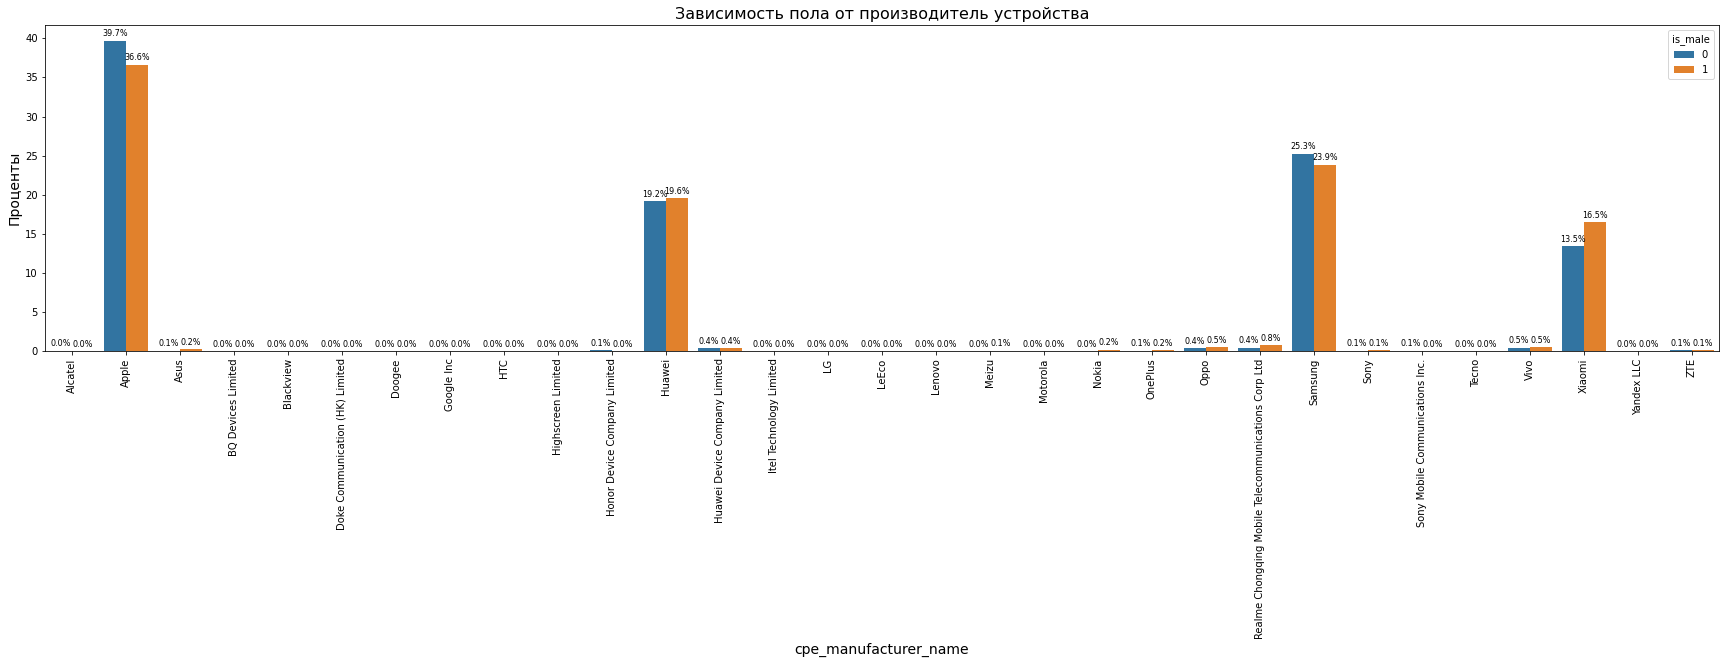

In [29]:
barplot_group('cpe_manufacturer_name', 'is_male', fin_df,
              'Зависимость пола от производителя устройства', 90)

In [30]:
data_group(data=fin_df, 
          col_main='cpe_manufacturer_name', 
          col_group='is_male')

   is_male                              cpe_manufacturer_name   Проценты
0        0                                              Apple  39.693975
1        0                                            Samsung  25.260960
2        0                                             Huawei  19.169085
3        0                                             Xiaomi  13.451679
4        0                                               Vivo   0.458029
5        0  Realme Chongqing Mobile Telecommunications Cor...   0.447857
6        0                                               Oppo   0.401158
7        0                      Huawei Device Company Limited   0.383183
8        0                       Honor Device Company Limited   0.122427
9        0                                                ZTE   0.112661


    is_male                              cpe_manufacturer_name   Проценты
31        1                                              Apple  36.630330
32        1                                    

In [31]:
data_group(data=fin_df, 
          col_main='cpe_model_name', 
          col_group='is_male')

   is_male   cpe_model_name   Проценты
0        0        iPhone 11  10.637959
1        0        iPhone XR   5.575349
2        0    Honor 10 Lite   3.409544
3        0         iPhone 7   3.238763
4        0  Galaxy A51 Dual   2.819540
5        0  Galaxy A50 Dual   2.635751
6        0    iPhone 8 Plus   2.428941
7        0         Honor 8X   1.898059
8        0         iPhone 8   1.854682
9        0         iPhone X   1.831908


     is_male    cpe_model_name  Проценты
482        1         iPhone 11  7.029393
483        1         iPhone XR  4.728068
484        1          iPhone 7  4.012901
485        1     Honor 10 Lite  3.112424
486        1   Galaxy A50 Dual  2.483400
487        1  Redmi Note 8 Pro  2.366070
488        1   Galaxy A51 Dual  2.182312
489        1          iPhone X  2.159156
490        1          Honor 8X  1.814470
491        1          iPhone 8  1.705097


**Вывод:**
Производитель устройства и его модель частично влияют на принадлежность к тому или иному полу. Гипотеза вероятнее подтвердилась.

## Гипотеза 3:
- Операционная система не влияет на целевую переменную.

In [32]:
pd.crosstab(index=fin_df.cpe_model_os_type,
            columns=fin_df.is_male,
            normalize='index')

is_male,0,1
cpe_model_os_type,,
Android,0.471527,0.528473
iOS,0.503965,0.496035


**Вывод:**
Операционная система устройства оказывает влияние пол. Женщины чаще предпочитаю iOS, а мужчмеы Android, что частично подтверждают и исследования выше. Гипотеза не подтвердилась.

## Гипотеза 4:
- Тип устройства влияет на пол пользователя. 

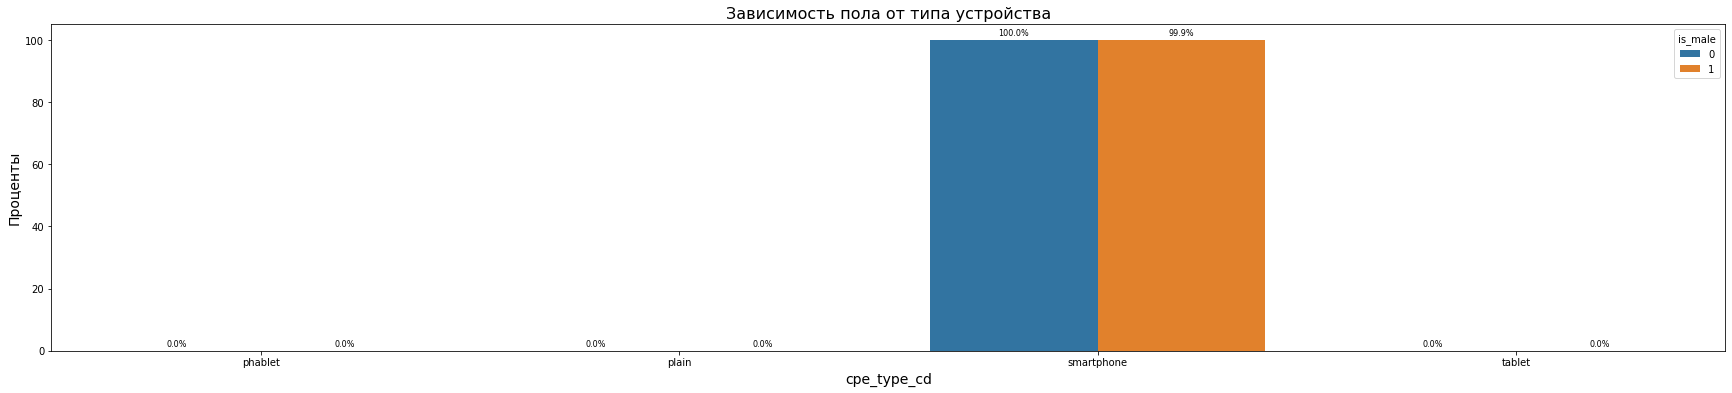

In [33]:
barplot_group('cpe_type_cd', 'is_male', fin_df,
              'Зависимость пола от типа устройства', 0)

In [34]:
pd.crosstab(index=fin_df.cpe_type_cd,
            columns=fin_df.is_male,
            normalize='index')

is_male,0,1
cpe_type_cd,,
phablet,0.012476,0.987524
plain,0.036044,0.963956
smartphone,0.484035,0.515965
tablet,0.163884,0.836116


**Вывод:**
Тип устройства влияет на принадлежность к полу. Мужчины, помимо смартфонов, чаще используют альтернативные устройства. Гипотеза подтвердилась. 

## Гипотеза 5:
- Цена устройства влияет на пол. 

In [35]:
def countplot_group(targ_main: str, data: pd.DataFrame,
                    exp_group: str, title: str) -> None:
    """
    Строит countplot
    """
 
    plt.figure(figsize=(15, 7))
    sns.countplot(x=exp_group, data=data, hue=targ_main)

    plt.xlabel(targ_main, fontsize=13)
    plt.ylabel('Количество', fontsize=13)
    plt.title(title, fontsize=15)

    plt.show()

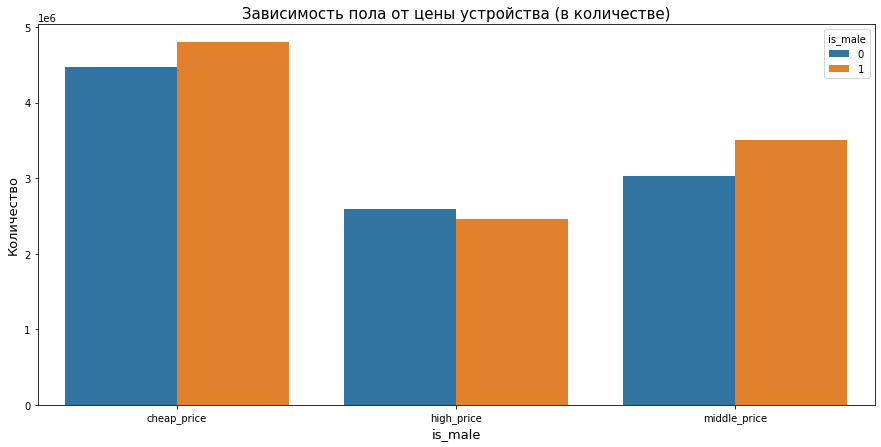

In [36]:
countplot_group('is_male', fin_df, 'bins_price',
                'Зависимость пола от цены устройства (в количестве)')

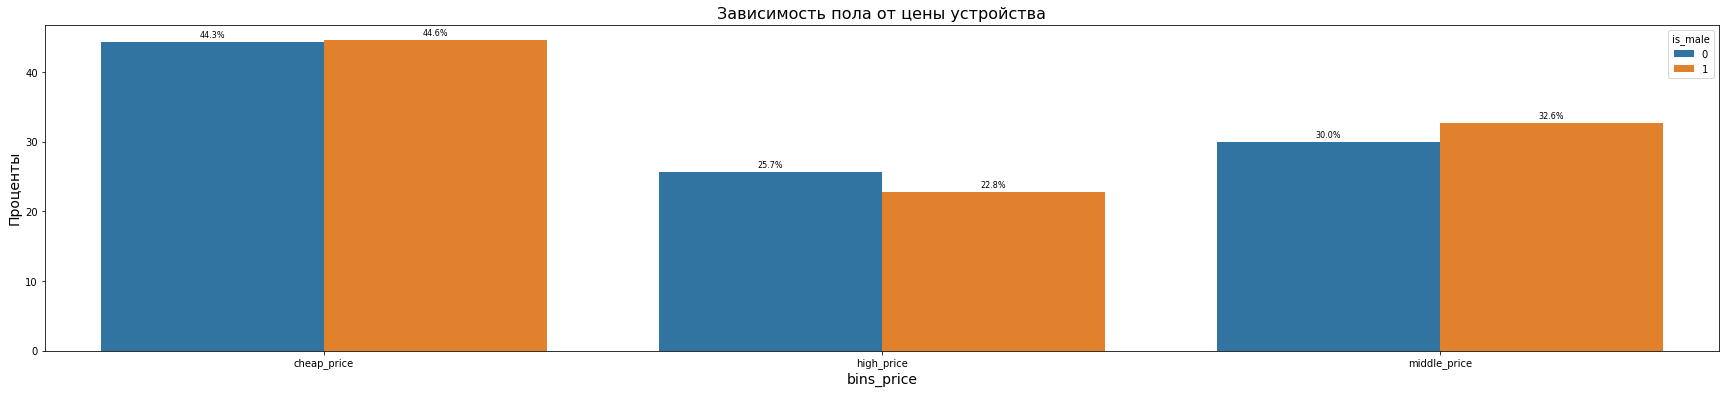

In [37]:
barplot_group('bins_price', 'is_male', fin_df,
              'Зависимость пола от цены устройства', 0)

In [38]:
pd.crosstab(index=fin_df.bins_price,
            columns=fin_df.is_male,
            normalize='index')

is_male,0,1
bins_price,,
cheap_price,0.482579,0.517421
high_price,0.513691,0.486309
middle_price,0.462724,0.537276


**Вывод:**
Цена устройства оказывает небольшое влияние на принадлежность к тому или иному полу. Так в дешевом и среднем сегментах преобладают пользователи мужского пола, а в дорогом - женского. Гипотеза подтвердилась. 

## Гипотеза 6:
- Женщины делают больше запросов за один день, чем мужчины. 

In [39]:
def displot_group(targ_main: str, data: pd.DataFrame,
                    exp_group: str, title: str) -> None:
    """
    Строит displot
    :param targ_main: целевой признак
    :param data: датасет
    :param exp_group: признак для анализа
    :param title: название графика
    :return: None
    """
    sns.displot(
    {
        'is_male 0': data[data[targ_main] == 0][exp_group],
        'is_male 1': data[data[targ_main] == 1][exp_group],
        
    },
    kind="kde",
    common_norm=False,
    height=8,
    aspect=2.5)

    plt.xlabel(targ_main, fontsize=15)
    plt.ylabel('Вероятность', fontsize=15)
    plt.title(title, fontsize=18)
    plt.show()

In [40]:
def boxplot_group(targ_main: str, data: pd.DataFrame,
                    exp_group: str, title: str) -> None:
    """
    Строит boxplot
    :param targ_main: целевой признак
    :param data: датасет
    :param exp_group: признак для анализа
    :param title: название графика
    :return: None
    """
    sns.boxplot(y=targ_main, x=exp_group, data=data, orient='h')

    plt.title(title, fontsize=18)
    plt.ylabel(targ_main, fontsize=15)
    plt.xlabel(exp_group, fontsize=15)
    plt.show()

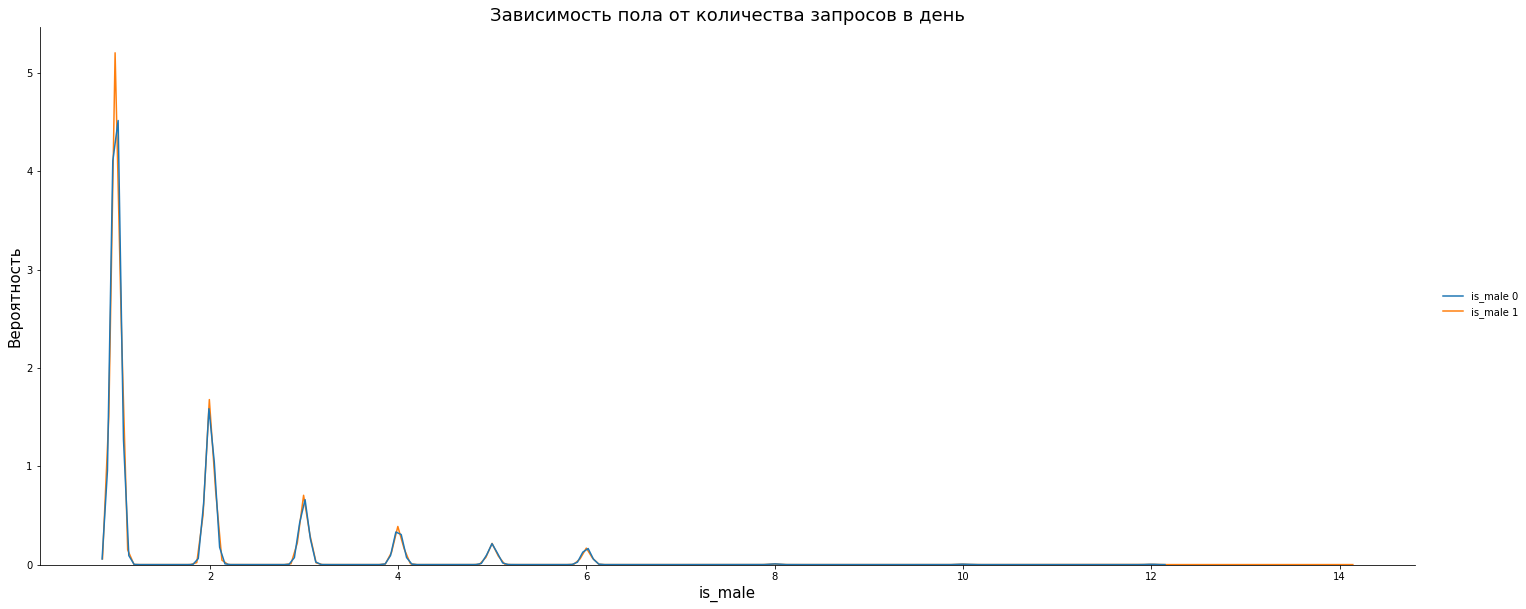

In [41]:
displot_group('is_male', fin_df, 'request_cnt',
              'Зависимость пола от количества запросов в день')

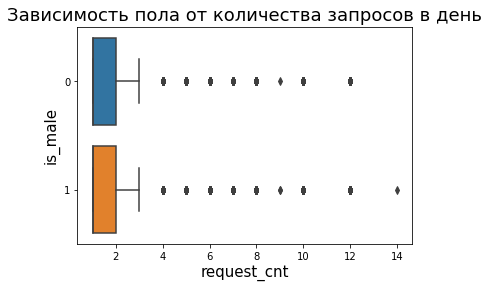

In [42]:
boxplot_group('is_male', fin_df, 'request_cnt',
              'Зависимость пола от количества запросов в день')

In [43]:
fin_df.groupby('is_male')['request_cnt'].median()

is_male
0    1.0
1    1.0
Name: request_cnt, dtype: float64

**Вывод:**
Вероятность того, что мужчины сделают от 1 до 4 запросов в день немного выше, но при количестве запросов от 5 до 12 она практически одинакова. В среднем оба пола делают по одному запросу в день. Гипотеза не подтвердилась. 

## Гипотеза 7:
- Женщины более активны в первой половине дня, чем мужчины. 

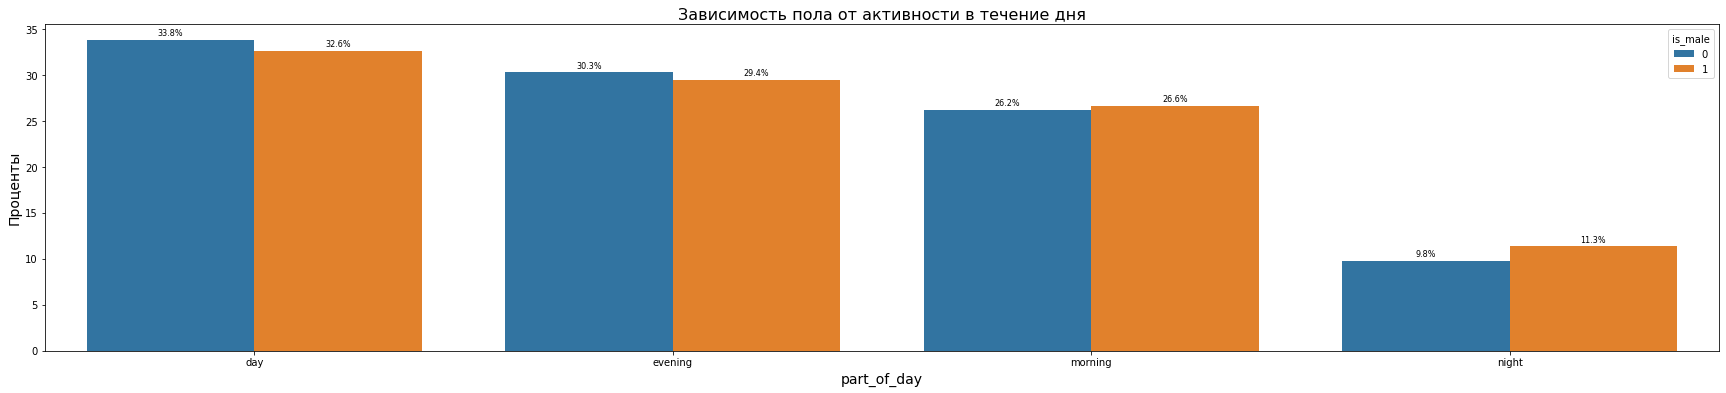

In [44]:
barplot_group('part_of_day', 'is_male', fin_df,
              'Зависимость пола от активности в течение дня', 0)

In [45]:
pd.crosstab(index=fin_df.part_of_day,
            columns=fin_df.is_male,
            normalize='index')

is_male,0,1
part_of_day,,
day,0.492710,0.507290
evening,0.491031,0.508969
morning,0.479706,0.520294
night,0.446483,0.553517


**Вывод:**
Пик активности женщин в дневное и вечернее время , а мужчины - утреннее и ночное. Гипотеза отчасти подтвердилась. 

## Гипотеза 8:
- Среди мужчины больше молодых людей, но в целом возраст не влияет на принадлежность к полу. 

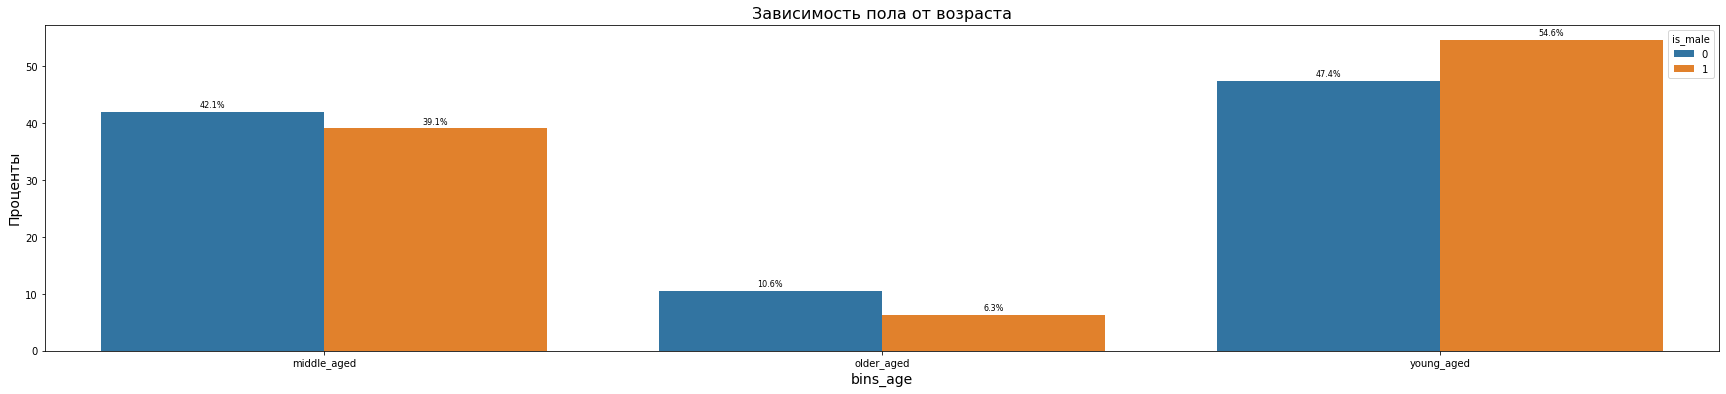

In [46]:
barplot_group('bins_age', 'is_male', fin_df,
              'Зависимость пола от возраста', 0)

In [47]:
pd.crosstab(index=fin_df.bins_age,
            columns=fin_df.is_male,
            normalize='index')

is_male,0,1
bins_age,,
middle_aged,0.502029,0.497971
older_aged,0.612879,0.387121
young_aged,0.448482,0.551518


**Вывод:**
Среди молодых людей больше мужчин, однако среди людей среднего и пожилого возраста преоладают женщины. Гипотеза подтвердилась. 

## Гипотеза 9:
- Месяц и его декады не влияют на таргет.

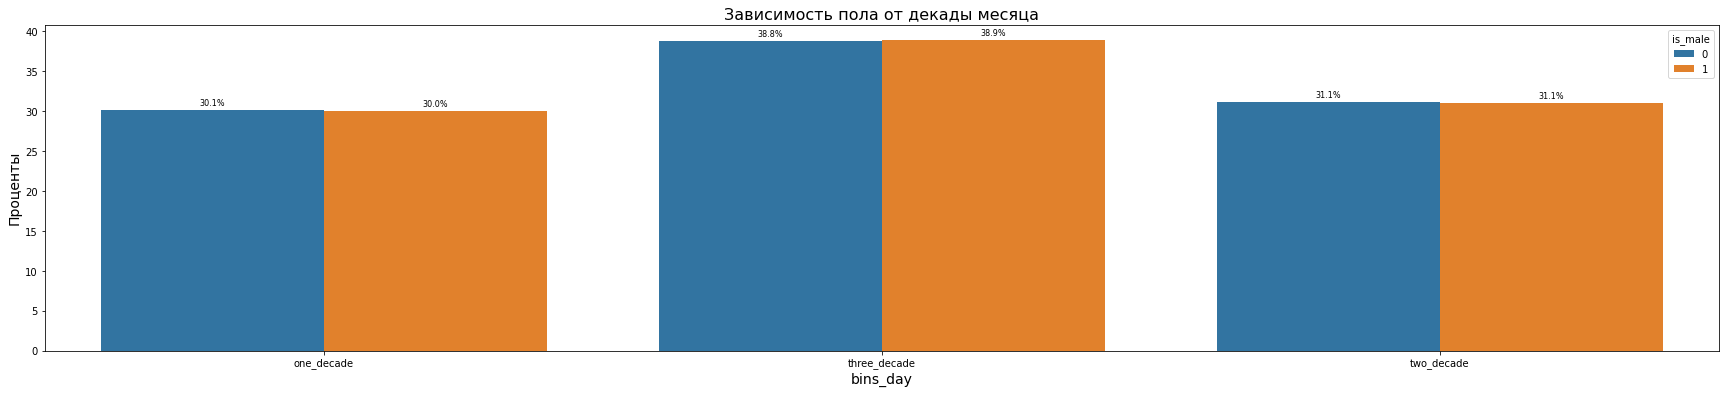

In [48]:
barplot_group('bins_day', 'is_male', fin_df,
              'Зависимость пола от декады месяца', 0)

In [49]:
pd.crosstab(index=fin_df.bins_day,
            columns=fin_df.is_male,
            normalize='index')

is_male,0,1
bins_day,,
one_decade,0.484608,0.515392
three_decade,0.482915,0.517085
two_decade,0.484413,0.515587


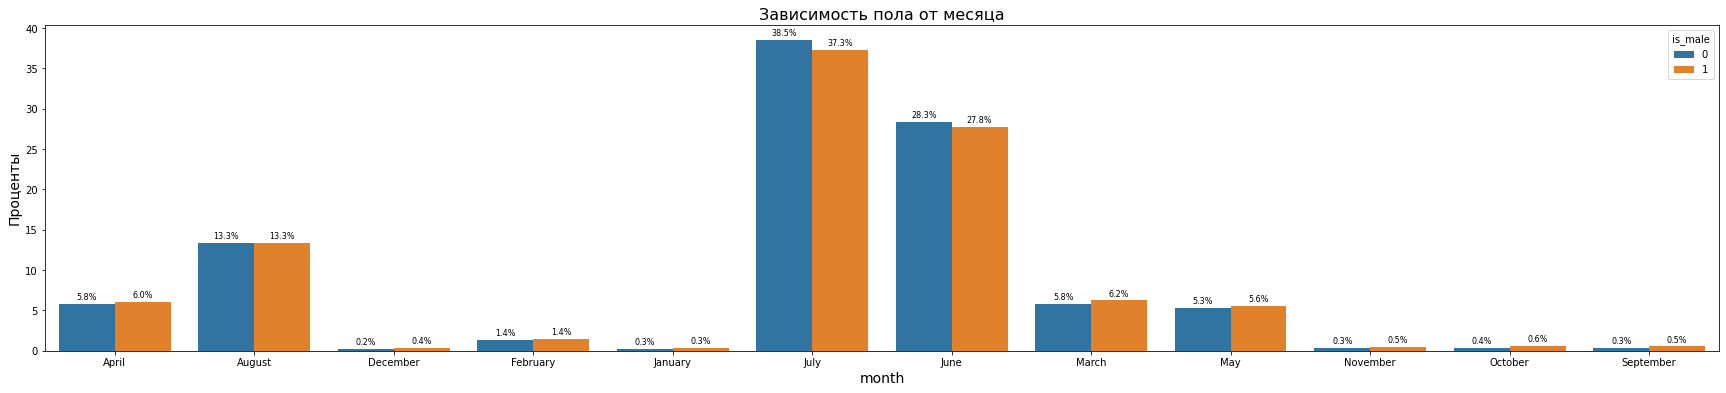

In [50]:
barplot_group('month', 'is_male', fin_df,
              'Зависимость пола от месяца', 0)

In [51]:
pd.crosstab(index=fin_df.month,
            columns=fin_df.is_male,
            normalize='index')

is_male,0,1
month,,
April,0.476243,0.523757
August,0.483932,0.516068
December,0.360769,0.639231
February,0.471743,0.528257
January,0.427543,0.572457
July,0.491518,0.508482
June,0.489023,0.510977
March,0.466362,0.533638
May,0.470933,0.529067


**Вывод:**
Пол не зависит от декады месяца. Но в тоже время от самого месяца зависит принадлежность к полу. Так в декабре, ноябре и сентябре пик активности у мужчин. А в июле, августе и июне у женщин. Гипотеза  подтвердилась лишь частично.

# Общие выводы:
1.  Регион и населенный пункт слабо влияют на принадлежность к тому или иному полу. В Москве и Санкт-Петербурге мужчин в целевой переменной больше, чем женщин;
2. Производитель устройства и его модель частично влияют на принадлежность к тому или иному полу. Женщины чуть более часто предпочитают продукцию Apple;
3. Операционная система устройства оказывает небольшое влияние пол. Женщины чаще использут iOS, а мужчины Android;
4. Тип устройства влияет на принадлежность к полу. Смартфонами пользуется практически одинаковое количество людей каждого пола, но мужчины также использут альтернативные устройства;
5. Цена устройства оказывает влияние на принадлежность к тому или иному полу. В дешевом и среднем сегментах преобладают пользователи мужского пола, а в дорогом - женского;
6. Вероятность того, что мужчины сделают от 1 до 3 запросов в день выше, но при количестве запросов от 5 до 12 она практически одинакова. В среднем оба пола делают по одному запросу в день;
7. Пик активности женщин в дневное и вечернее время , а мужчины - утреннее и ночное. ;
8. Среди молодых людей больше мужчин, однако среди людей среднего и пожилого возраста преоладают женщины;
9. Пол не зависит от декады месяца. Но в тоже время от самого месяца зависит принадлежность к полу. Так в декабре, январе и сентябре пик активности у мужчин. А в июле, августе и ноябре у женщин.

# Получение эмбеддингов

In [52]:
# аггрегирует данные
def data_aggregate(data: pd.DataFrame, list_select, list_group) -> pa.Table:
    '''
    Преобразует в формат pa.Table, группирует и аггрегирует данные
    :param data: датасет
    :param list_select: используемые признаки из датасета
    :param list_group: группируемые признаки
    :return: pa.Table
    '''
    fin_df_pq = pa.Table.from_pandas(data)    
    data_agg = fin_df_pq.select(list_select).group_by(list_group).aggregate([
                          ('month', 'count_distinct'),
                          ('city_name', 'count_distinct'),
                          ('cpe_model_name', 'count_distinct'),
                          ('bins_price', 'count_distinct'),
                          ('part_of_day', 'count_distinct'),
                          ('bins_age', 'count_distinct')])
    return data_agg

In [53]:
data_agg = data_aggregate(data=fin_df, 
                          list_select=preproc['list_select'],
                          list_group=preproc['list_group'])

In [54]:
# создает словари url и user
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

63055 urls
26501 users


In [55]:
def gen_mat(dat: str, user: str, url: str) -> scipy.sparse.coo_matrix:
    """
    Генерирует разряженные матрицы
    """
    values = np.array(data_agg.select([dat]).to_pandas()[[dat]])
    rows = np.array(data_agg.select([user]).to_pandas()[user].map(usr_dict))
    cols = np.array(data_agg.select([url]).to_pandas()[url].map(url_dict))
    mat = scipy.sparse.coo_matrix((values.reshape((len(values))), (rows, cols)), 
                                      shape=((rows.max() + 1), 
                                             (cols.max() + 1).astype('int64')))
    return mat

In [56]:
mat_1 = gen_mat(dat='month_count_distinct', 
        user='user_id', 
        url='url_host')

In [57]:
mat_2 = gen_mat(dat='city_name_count_distinct', 
        user='user_id', 
        url='url_host')

In [58]:
mat_3 = gen_mat(dat='cpe_model_name_count_distinct', 
        user='user_id', 
        url='url_host')

In [59]:
mat_4 = gen_mat(dat='bins_price_count_distinct', 
        user='user_id', 
        url='url_host')

In [60]:
mat_5 = gen_mat(dat='part_of_day_count_distinct', 
        user='user_id', 
        url='url_host')

In [61]:
mat_6 = gen_mat(dat='bins_age_count_distinct', 
        user='user_id', 
        url='url_host')

In [62]:
# создает обобщенную разряженную матрицу
fin_mat = scipy.sparse.hstack((mat_1, mat_2, mat_3, mat_4, mat_5, mat_6)).tocsr()

In [63]:
als = implicit.als.AlternatingLeastSquares(factors=preproc['factors'], 
                                           iterations=preproc['iterations'], 
                                           use_gpu = False, 
                                           calculate_training_loss = False, 
                                           regularization=preproc['regularization'],
                                           random_state=preproc['random_state'])

In [64]:
als.fit(fin_mat)

  0%|          | 0/30 [00:00<?, ?it/s]

In [65]:
als_path = preproc['als_path']
joblib.dump(als, als_path)

['../../../../Курс_по_DS/Pet_project/Production/Data/Processed/model_als.joblib']

In [66]:
# массив скрытых факторов для пользователей
u_factors = als.user_factors 

In [67]:
# создает итоговый Dataframe
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
df = target_train.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].astype('int8')
df['is_male'].value_counts()

1    13498
0    13002
Name: is_male, dtype: int64

In [68]:
df.to_csv(preproc['df_path_proc'])